# Analisis de datos sobre consumo de sustancias psicoactivas

*import's* generales <br>Proyect hecho en Python 3.12.7

In [53]:
import pandas as pd
pd.set_option('future.no_silent_downcasting', True)

Obtener los datos correspondientes

In [54]:
dconsum = pd.read_csv("drug_consumption.csv")
dconsum.drop("ID", axis = 1, inplace = True)
dconsum.head()

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,...,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,Semer,VSA
0,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
1,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
2,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
3,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
4,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


Cuantificar categorias relacionadas al consumo de sustancias, dejando simplemente el digito
```Value	Description
CL0	Never Used
CL1	Used over a Decade Ago
CL2	Used in Last Decade
CL3	Used in Last Year
CL4	Used in Last Month
CL5	Used in Last Week
CL6	Used in Last Day```

In [55]:
quant_cat = {
    'CL0': 0,
    'CL1': 1,
    'CL2': 2,
    'CL3': 3,
    'CL4': 4,
    'CL5': 5,
    'CL6': 6,
}

dconsum.iloc[:,12:] = dconsum.iloc[:,12:].replace(quant_cat) 
dconsum.head()

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,...,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,Semer,VSA
0,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,0,0,0,0,0,0,0,2,0,0
1,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,4,0,2,0,2,3,0,4,0,0
2,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,0,0,0,0,0,0,1,0,0,0
3,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,0,0,2,0,0,0,0,2,0,0
4,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,1,0,0,1,0,0,2,2,0,0


Obtenemos la columna realcionada con sustancias mas balanceada (tiene una cantidad similar de consumidores y no consumidores *CL0* )

In [56]:
def balanced_col(df, value):
    percentages = {} # Disctionary with percentages for each column
    
    #Precentage for each column
    for column in df.columns:
        count = df[column].eq(value).sum()
        total = len(df[column])
        precentage = (count/total) * 100
        percentages[column] = precentage #Store the result in the dictionary

    # Find the column with percentage closest to 50%
    closest_column = min(percentages, key=lambda x: abs(percentages[x] - 50))
    
    return percentages, closest_column

percentages, closest_column = balanced_col(dconsum.iloc[:,12:], 0)
print("La sustancia con mayor balance entre consumidores y no consumidores es " + closest_column)

La sustancia con mayor balance entre consumidores y no consumidores es Amphet


Convertimos `Amphet` en una columna que nos dice si consumio o nunca ha consumido

In [57]:
def clas_quant(value):
    if(value == 0):
        return 0
    return 1

dconsum["Amphet"] = dconsum["Amphet"].apply(clas_quant)

## Modelos para la clasificacion de consumidores de Anfetaminas

La premisa de nuestros modelos va a ser decidir si una persona es una potencial consumidora de anfetaminas en base a los datos proporcionados en `dconsum`, aplicando tambien un analisis estadistico.

Para esto usaremos los siguientes modelos estadisticos
- Regresion logistica
- KNN
- SVN
- Discriminante Lineal

Con las siguientes metricas de desempe;o
- F1-Score
- Recall
- Accuracy

Para esto es importante separar nuestras variables independientes y dependiente, ya que esto sera de utilidad en todos nuestros modelos

In [58]:
X = dconsum.iloc[:, dconsum.columns != 'Amphet']
X = X.apply(pd.to_numeric, errors='coerce')
y = dconsum["Amphet"]

Es importante tener en cuenta que en los modelos de regresión logística, SVN y discriminante lineal se usará un *random_state* (númerico) que indica como "revolver" los datos, al cambiar este dato, la precisión del modelo puede cambiar, es por eso que debemos buscar el valor de random_state que genere la mejor precisión de cada modelo.

Para eso, iniciamos definiendo una función que recibe el tipo del modelo, siendo:
Regresión logística (1),
KNN (2)(*Este no aplica*),
SVN (3),
Discriminante lineal (4),
X (variable independiente),
y (variable dependiente),
random_state (valor numerico). Esta función retornará las metricas del modelo elegido según el random_state dado.
La relación de entrenamiento-pruebas será 80-20

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report,accuracy_score

def create_model(model_type, X, y, random_state):
    # Dividir los datos en conjunto de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
    # Seleccionar el modelo según el tipo
    if model_type == 1:
        model = LogisticRegression(max_iter=1000)
    elif model_type == 2:
        model = KNeighborsClassifier()
    elif model_type == 3:
        model = SVC(kernel='linear', C=1)
    elif model_type == 4:
        model = LinearDiscriminantAnalysis()
    else:
        raise ValueError("model_type debe ser 1, 2, 3 o 4")
    
    # Entrenar el modelo
    model.fit(X_train, y_train)
    
    # Hacer predicciones
    y_pred = model.predict(X_test)
    
    # Obtener las métricas de evaluación
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Retornar las métricas de interés (accuracy, precision, recall, f1-score)
    accuracy = report['accuracy']
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']
    
    return accuracy, precision, recall, f1

Posteriormente, definimos una función que nos retorne el random_state con las mejores metricas dado determinado modelo (valores el 1 al 4 definidos en la anterior función).

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def print_results(results_df):
    plt.figure(figsize=(14, 8))
    plt.plot(results_df['random_state'], results_df['accuracy'], label='Accuracy', marker='o')
    plt.plot(results_df['random_state'], results_df['precision'], label='Precision', marker='o')
    plt.plot(results_df['random_state'], results_df['recall'], label='Recall', marker='o')
    plt.plot(results_df['random_state'], results_df['f1_score'], label='F1-Score', marker='o')
    plt.plot(results_df['random_state'], results_df['average'], label='Average', marker='o')
    plt.xlabel('Random State')
    plt.ylabel('Metric Value')
    plt.title('Variación de las métricas según el Random State')
    plt.legend()
    plt.grid(True)
    plt.show()
def find_best_metrics(model_type, X, y):
    random_states = np.arange(1, 101)  # 100 valores de random state
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    averages = []

    # Evaluar el modelo con diferentes random states
    for state in random_states:
        accuracy, precision, recall, f1 = create_model(model_type, X, y, state)
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        averages.append((precision + recall + f1) / 3)
        
    # Crear el DataFrame con los resultados
    results_df = pd.DataFrame({
        'random_state': random_states,
        'accuracy': accuracies,
        'precision': precisions,
        'recall': recalls,
        'f1_score': f1_scores,
        'average': averages
    })
    #Para imprimir el dataframe
    
    print_results(results_df)
    
    # Identificar el mejor random_state según el promedio
    best_index = results_df['average'].idxmax() # Se suma 1 porque el índice comienza en 0, y los random states en 1
    best_random_state = results_df.loc[best_index, 'random_state']
    best_accuracy = results_df.loc[best_index, 'accuracy']
    best_precision = results_df.loc[best_index, 'precision']
    best_recall = results_df.loc[best_index, 'recall']
    best_f1 = results_df.loc[best_index, 'f1_score']
        
    # Retornar las métricas del mejor random_state
    return best_random_state, best_accuracy, best_precision, best_recall, best_f1

### Modelo de regresion logistica

In [61]:
import statsmodels.api as sm

def clean_dataset(X, y, threshold=0.05):
    # Add a constant for the intercept term
    X = sm.add_constant(X)
    
    # Get the p-values
    model = sm.Logit(y, X).fit(disp=False)
    p_values = model.pvalues.drop('const')
    
    # Loop to remove variables with p-values greater than the threshold
    while p_values.max() > threshold:
        to_drop = p_values.idxmax() #Drop the variable with the highest p-value
        
        print(f"\nRemoving variable: {to_drop} with p-value: {p_values.max()}")
        
        # Remove the variable from the dataset
        X = X.drop(columns=[to_drop])
        
        # Get the updated p-values
        model = sm.Logit(y, X).fit(disp=False)
        p_values = model.pvalues.drop('const')
    
    return X

X_reduc = clean_dataset(X, y)



Removing variable: Ketamine with p-value: 0.9624978842015393

Removing variable: Mushrooms with p-value: 0.8488077845726859

Removing variable: Choc with p-value: 0.7278496368496175

Removing variable: Cscore with p-value: 0.7063567031792226

Removing variable: Ethnicity with p-value: 0.6177658196423583

Removing variable: Country with p-value: 0.5915959757842191

Removing variable: Legalh with p-value: 0.5059085488451447

Removing variable: Semer with p-value: 0.29216048498571057

Removing variable: Caff with p-value: 0.2629005672418927

Removing variable: Oscore with p-value: 0.251051317634981

Removing variable: Nscore with p-value: 0.28973608892048663

Removing variable: Impulsive with p-value: 0.1915516280687628

Removing variable: Crack with p-value: 0.14143273238454232

Removing variable: Education with p-value: 0.13438574325928757

Removing variable: Gender with p-value: 0.16494458222569874

Removing variable: Ascore with p-value: 0.18102545094719902

Removing variable: VSA wi

Hallamos las mejores metricas para este modelo

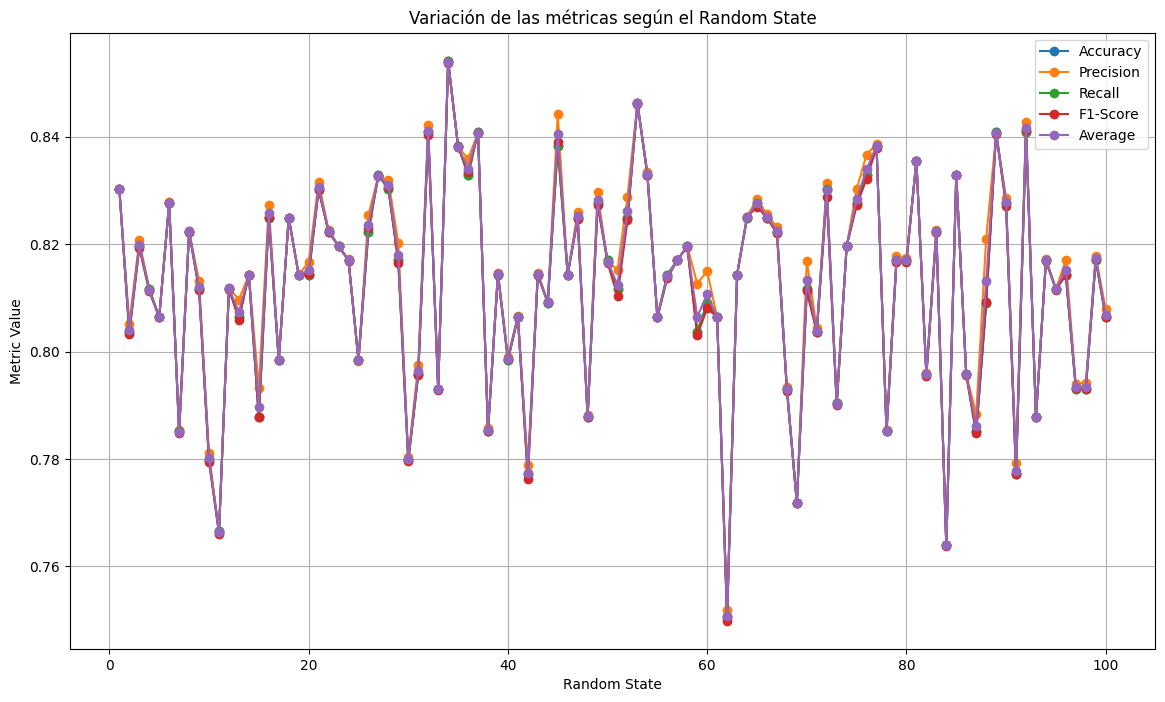

Mejor random state: 34
Mejor accuracy: 0.8541114058355438
Mejor precision: 0.8540083590683291
Mejor recall: 0.8541114058355438
Mejor f1-score: 0.8537608349959996


In [62]:
best_random_state, best_accuracy, best_precision, best_recall, best_f1 = find_best_metrics(1, X_reduc, y)
print(f"Mejor random state: {best_random_state}")
print(f"Mejor accuracy: {best_accuracy}")
print(f"Mejor precision: {best_precision}")
print(f"Mejor recall: {best_recall}")
print(f"Mejor f1-score: {best_f1}")


Ahora, creamos un modelo con el random state obtenido y extraemos sus metricas

In [63]:
from sklearn.metrics import accuracy_score
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_reduc, y, test_size=0.2, random_state=best_random_state)
# Crear el modelo de regresión logística
model = LogisticRegression(max_iter=1000)  # Aumenta las iteraciones si es necesario

# Entrenar el modelo
model.fit(X_train_lr, y_train_lr)

# Hacer predicciones
y_pred_lr = model.predict(X_test_lr)

# Obtener las métricas como diccionario
report = classification_report(y_test_lr,y_pred_lr,output_dict=True)

a1 = accuracy_score(y_test_lr, y_pred_lr)


Por último mostramos la matriz de confusión.

In [64]:
from sklearn.metrics import confusion_matrix
matrix_confusion_linear_regression = confusion_matrix(y_test_lr, y_pred_lr)
print(matrix_confusion_linear_regression)


[[185  24]
 [ 31 137]]


### Modelo de KNN

In [65]:
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

def drop_least_important_features(X, y, n_neighbors=5, threshold=0.01):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    while True:
        # Dividir los datos y entrenar el modelo
        knn.fit(X, y)
        
        # Calcular importancia de las características mediante permutación
        result = permutation_importance(knn, X, y, n_repeats=10, random_state=42, n_jobs=-1)
        
        # Obtener la importancia mínima
        min_importance = result.importances_mean.min()
        
        # Si la importancia más baja es mayor que el umbral, detenemos
        if min_importance > threshold:
            break
        
        # Identificar y eliminar la característica menos importante
        least_important_feature = X.columns[result.importances_mean.argmin()]
        X = X.drop(columns=[least_important_feature])
        print(f'Eliminando característica: {least_important_feature}')
    
    return X

# Aplicar la función para eliminar características menos importantes
X_reduced = drop_least_important_features(X, y)

Eliminando característica: Oscore
Eliminando característica: Nscore
Eliminando característica: Ketamine
Eliminando característica: Education
Eliminando característica: Country


KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=45)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def find_best_k(X_train, X_test, y_train, y_test, k_range=range(1, 40), cv=2):
    # Define the KNN model
    knn = KNeighborsClassifier()

    # Define the values of k to evaluate
    param_grid = {'n_neighbors': list(k_range)}

    # Use GridSearchCV to test the values of k
    grid_search = GridSearchCV(knn, param_grid, cv=cv, scoring='accuracy')

    # Fit the model to the training data
    grid_search.fit(X_train, y_train)

    # Get the best value of k
    best_k = grid_search.best_params_['n_neighbors']

    # Evaluate the model with the best number of neighbors
    best_knn = grid_search.best_estimator_
    y_pred = best_knn.predict(X_test)

    # Print the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)

    return best_k, accuracy


best_k, best_accuracy = find_best_k(X_train, X_test, y_train, y_test)


#Se debe cambiar esta implementación para usar la función de find_best_metrics con este modelo
#se debe tener en cuenta el valor del k a la hora de hacer la evaluación
#Para jorge.
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
print(f'Best k: {best_k} ')
y_pred = knn.predict(X_test)
a2 = accuracy_score(y_test, knn.predict(X_test))


Best k: 19 


/home/david/.local/lib/python3.9/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Metricas de desempe;o

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.72      0.81       217
           1       0.71      0.92      0.80       160

    accuracy                           0.80       377
   macro avg       0.81      0.82      0.80       377
weighted avg       0.83      0.80      0.80       377



Matriz de confusion

In [ ]:
m2 = confusion_matrix(y_test, y_pred)

### Modelo de SVM

In [ ]:
X_reduc = clean_dataset(X, y)


Removing variable: Ketamine with p-value: 0.9624978842015393

Removing variable: Mushrooms with p-value: 0.8488077845726859

Removing variable: Choc with p-value: 0.7278496368496175

Removing variable: Cscore with p-value: 0.7063567031792226

Removing variable: Ethnicity with p-value: 0.6177658196423583

Removing variable: Country with p-value: 0.5915959757842191

Removing variable: Legalh with p-value: 0.5059085488451447

Removing variable: Semer with p-value: 0.29216048498571057

Removing variable: Caff with p-value: 0.2629005672418927

Removing variable: Oscore with p-value: 0.251051317634981

Removing variable: Nscore with p-value: 0.28973608892048663

Removing variable: Impulsive with p-value: 0.1915516280687628

Removing variable: Crack with p-value: 0.14143273238454232

Removing variable: Education with p-value: 0.13438574325928757

Removing variable: Gender with p-value: 0.16494458222569874

Removing variable: Ascore with p-value: 0.18102545094719902

Removing variable: VSA wi

Hallamos las mejores metricas para este modelo

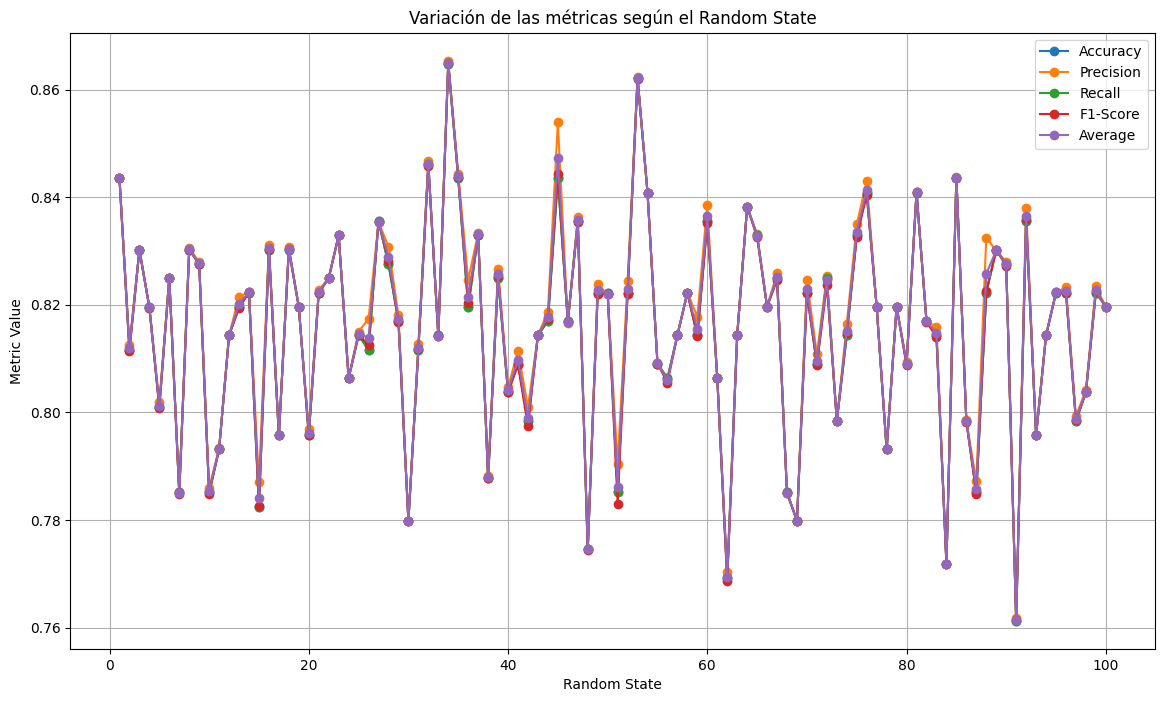

Mejor random state: 34
Mejor accuracy: 0.8647214854111406
Mejor precision: 0.865372740224714
Mejor recall: 0.8647214854111406
Mejor f1-score: 0.8648943861703804


In [ ]:
best_random_state, best_accuracy, best_precision, best_recall, best_f1 = find_best_metrics(3, X_reduc, y)
print(f"Mejor random state: {best_random_state}")
print(f"Mejor accuracy: {best_accuracy}")
print(f"Mejor precision: {best_precision}")
print(f"Mejor recall: {best_recall}")
print(f"Mejor f1-score: {best_f1}")


Ahora, creamos un modelo con el random state obtenido y extraemos sus metricas

In [ ]:
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_reduc, y, test_size=0.2, random_state=best_random_state)
# Crear el modelo de regresión logística
model = SVC(kernel='linear', C=1)

# Entrenar el modelo
model.fit(X_train_svm, y_train_svm)

# Hacer predicciones
y_pred_svm = model.predict(X_test_svm)

# Obtener las métricas como diccionario
report = classification_report(y_test_svm,y_pred_svm,output_dict=True)

a3 = accuracy_score(y_test_svm, y_pred_svm)


Por último mostramos la matriz de confusión.

In [ ]:
from sklearn.metrics import confusion_matrix
matrix_confusion_SVM = confusion_matrix(y_test_svm, y_pred_svm)
print(matrix_confusion_SVM)

[[181  28]
 [ 23 145]]


### Modelo de discriminante lineal

Hallamos las mejores metricas para este modelo


Removing variable: Ketamine with p-value: 0.9624978842015393

Removing variable: Mushrooms with p-value: 0.8488077845726859

Removing variable: Choc with p-value: 0.7278496368496175

Removing variable: Cscore with p-value: 0.7063567031792226

Removing variable: Ethnicity with p-value: 0.6177658196423583

Removing variable: Country with p-value: 0.5915959757842191

Removing variable: Legalh with p-value: 0.5059085488451447

Removing variable: Semer with p-value: 0.29216048498571057

Removing variable: Caff with p-value: 0.2629005672418927

Removing variable: Oscore with p-value: 0.251051317634981

Removing variable: Nscore with p-value: 0.28973608892048663

Removing variable: Impulsive with p-value: 0.1915516280687628

Removing variable: Crack with p-value: 0.14143273238454232

Removing variable: Education with p-value: 0.13438574325928757

Removing variable: Gender with p-value: 0.16494458222569874

Removing variable: Ascore with p-value: 0.18102545094719902

Removing variable: VSA wi

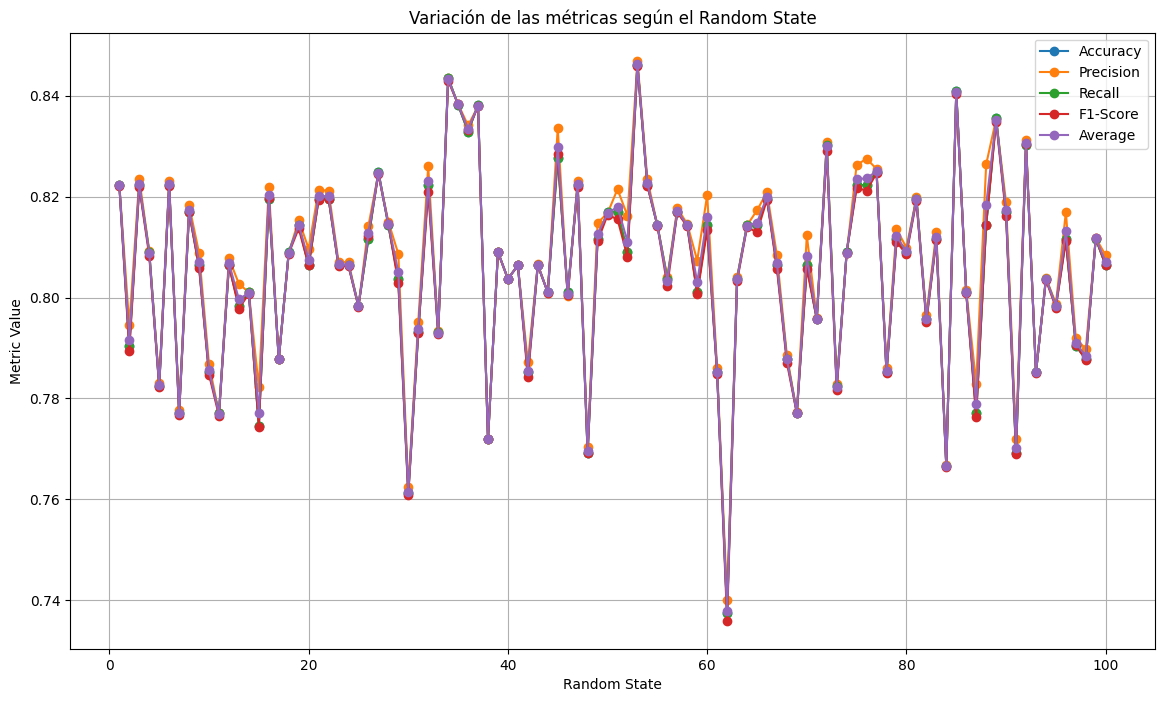

Mejor random state: 53
Mejor accuracy: 0.8461538461538461
Mejor precision: 0.8469378421815997
Mejor recall: 0.8461538461538461
Mejor f1-score: 0.8459476587968209


In [ ]:
X_reduc = clean_dataset(X, y)
best_random_state, best_accuracy, best_precision, best_recall, best_f1 = find_best_metrics(4, X_reduc, y)
print(f"Mejor random state: {best_random_state}")
print(f"Mejor accuracy: {best_accuracy}")
print(f"Mejor precision: {best_precision}")
print(f"Mejor recall: {best_recall}")
print(f"Mejor f1-score: {best_f1}")


Ahora, creamos un modelo con el random state obtenido y extraemos sus metricas

In [ ]:
X_train_ld, X_test_ld, y_train_ld, y_test_ld = train_test_split(X_reduc, y, test_size=0.2, random_state=best_random_state)
# Crear el modelo de regresión logística
model = LinearDiscriminantAnalysis()

# Entrenar el modelo
model.fit(X_train_ld, y_train_ld)

# Hacer predicciones
y_pred_ld = model.predict(X_test_ld)

# Obtener las métricas como diccionario
report = classification_report(y_test_ld,y_pred_ld,output_dict=True)

a4 = accuracy_score(y_test_ld, y_pred_ld)


Por último mostramos la matriz de confusión.

In [ ]:
from sklearn.metrics import confusion_matrix
matrix_confusion_linear_discriminant = confusion_matrix(y_test_ld, y_pred_ld)
print(matrix_confusion_linear_discriminant)

[[169  24]
 [ 34 150]]


### Resultados finales

Por último, imprimimos las matrices de confusión de cada modelo

Matriz de confusión de la regresión logística


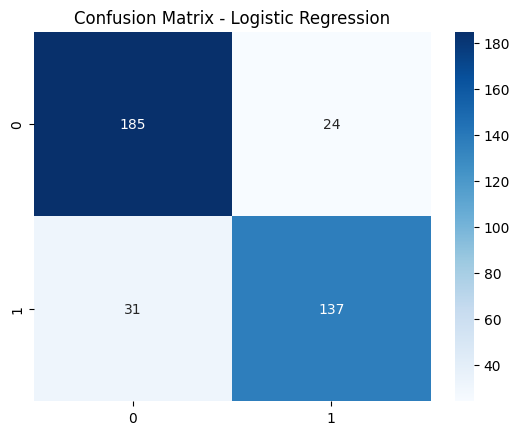

Matriz de confusión de SVM


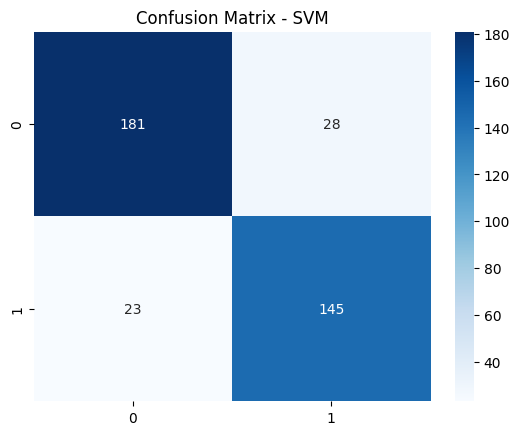

Matriz de confusión de LDA


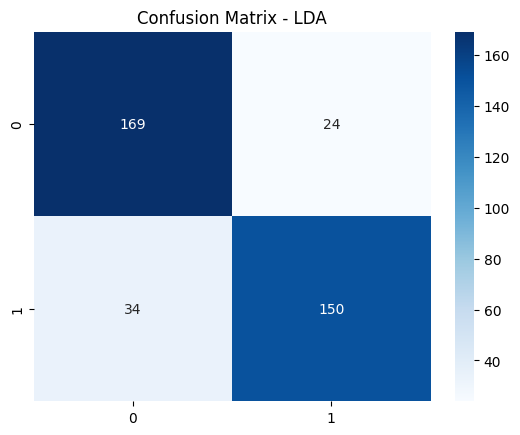

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Logistic Regression Confusion Matrix
print("Matriz de confusión de la regresión logística")
plt.figure()
sns.heatmap(matrix_confusion_linear_regression, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# SVM Confusion Matrix
print("Matriz de confusión de SVM")
plt.figure()
sns.heatmap(matrix_confusion_SVM, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - SVM")
plt.show()

# LDA Confusion Matrix
print("Matriz de confusión de LDA")
plt.figure()
sns.heatmap(matrix_confusion_linear_discriminant, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - LDA")
plt.show()

In [66]:
a1, a2, a3, a4

(0.8541114058355438,
 0.8037135278514589,
 0.8620689655172413,
 0.8461538461538461)